## Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Dataset

In [ ]:
# 1. Load dataset
data = pd.read_csv('car.csv')
data.columns = data.columns.str.strip()

# 2. Feature engineering
data['car_age'] = 2025 - data['year']
data.drop(columns='year', inplace=True)

# 3. Log transform km_driven to reduce skew
data['km_driven'] = np.log1p(data['km_driven'])

# 4. Remove extreme outliers in price
data = data[data['selling_price'] < data['selling_price'].quantile(0.99)]

# 5. Add km_per_year
data['km_per_year'] = np.round(np.expm1(data['km_driven']) / data['car_age'], 2)
data['km_per_year'] = np.log1p(data['km_per_year'])

# 6. Add price_per_km
data['price_per_km'] = data['selling_price'] / np.expm1(data['km_driven'])
data['price_per_km'] = np.log1p(data['price_per_km'])  # reduce skew

# 7. Define features and target
X = data.drop(columns=['selling_price', 'name'])  # name is dropped
y = data['selling_price']

## One-Hot Encoding

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner']
# Create the column transformer
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Keep other (numerical) columns as is
)
X_transformed = ct.fit_transform(X)


In [ ]:
print(X[:5])

   km_driven    fuel seller_type transmission         owner  car_age  \
0  11.156265  Petrol  Individual       Manual   First Owner       18   
1  10.819798  Petrol  Individual       Manual   First Owner       18   
2  11.512935  Diesel  Individual       Manual   First Owner       13   
3  10.736418  Petrol  Individual       Manual   First Owner        8   
4  11.856522  Diesel  Individual       Manual  Second Owner       11   

   km_per_year  price_per_km  
0     8.266136      0.619039  
1     7.929767      1.308333  
2     8.948106      1.945910  
3     8.657129      1.861718  
4     9.458698      1.433056  


## Spliting Dataset


In [ ]:
## Spliting Dataset
# Split X and transformed y
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
y_train_trans = np.log1p(y_train.values)

## Training Model

In [ ]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 300),             # Number of trees in the forest
    'max_depth': [10, 20, None],                   # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],               # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],                 # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2']               # Number of features to consider when looking for best split
}

# Set up RandomizedSearchCV with Random Forest
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),  # Base estimator
    param_distributions=param_dist,                    # Parameter space to search
    n_iter=10,                                          # Number of parameter settings to sample
    cv=3,                                               # 3-fold cross-validation
    scoring='r2',                                       # Use R² as scoring metric
    n_jobs=-1,                                          # Use all available cores
    verbose=2,                                          # Show detailed progress
    random_state=42                                     # Reproducibility
)

# Fit the RandomizedSearchCV on training data
random_search.fit(X_train, y_train_trans)

# Retrieve the best performing model
best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


## Predict

In [ ]:
# Predict target values on test set (log scale)
y_pred_trans = best_model.predict(X_test)

# Inverse transform predictions to original scale
y_pred = np.expm1(y_pred_trans)  # Matches the log1p transformation used earlier

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)                  # Mean Squared Error
rmse = np.sqrt(mse)                                       # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)                 # Mean Absolute Error
r2 = r2_score(y_test, y_pred)                             # R² Score

# Print evaluation results
print("Optimized R² Score     :", round(r2, 4))
print("Mean Squared Error     :", round(mse, 2))
print("Root Mean Squared Error:", round(rmse, 2))
print("Mean Absolute Error     :", round(mae, 2))
print("Best Hyperparameters    :", random_search.best_params_)

Optimized R2 Score: 0.8587638190324229
Optimized MSE: 19202553705.631813
RMSE: 138573.279190585
MAE: 58281.46803254747
Best Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 108}


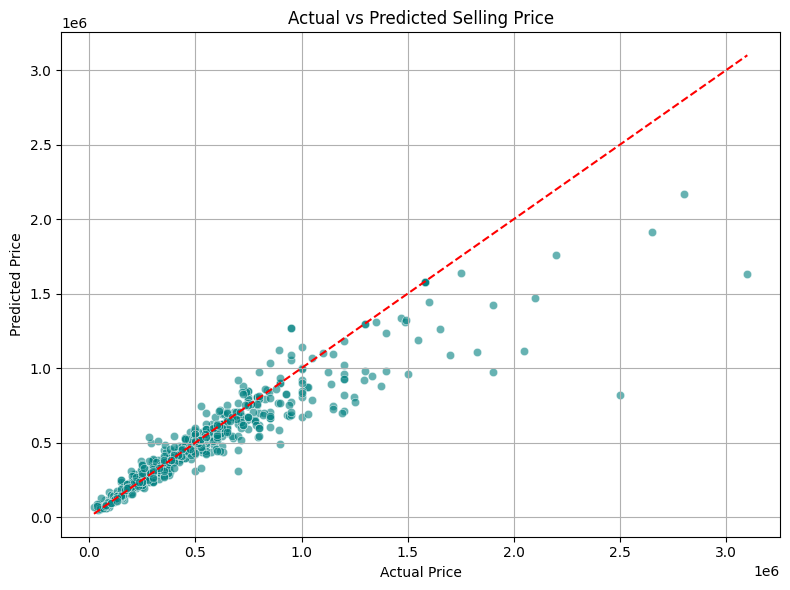

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred.ravel(), alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Selling Price')
plt.grid(True)
plt.tight_layout()
plt.show()